# POPPY Simulation: MagAO-X for PDR (Master file)
## Notes: 
- This file has aberrations present due to PSDs on the optical surfaces.
- For the no-aberrations version, please visit: https://github.com/jlumbres/magaox_poppy/blob/master/magaox_pdr_noFITS.ipynb
- This notebook generates the F/69 Science PSFs. All intermediary F/# PSFs are dropped.
- There are a lot of pink warnings present in this notebook. Please ignore them, they are a POPPY thing and do not affect the output.

In [1]:
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm 
#POPPY
import poppy
from poppy.poppy_core import PlaneType
print("POPPY Version: "+poppy.__version__)

POPPY Version: 0.6.0rc1


## Initiate the optical elements and variables
- The values for the Magellan telescope and MagAO-X are pulled from Oli Durney's Zemax file.

### Optical elements not implemented currently:
- ADC1 (surface 4&5, 7&8)
- ADC2 (surface 6&7, 9&10)

### To-do Tasks:
- Fix the path to go through the coronagraph path.
- Figure out how to pull out the phase and amplitude from F/69 science PSF.

In [2]:
# note: u.m is in meters
testWavelength = 656e-9 * u.m # H-alpha
npix = 256  # resolution

# physical radius values
M1_radius = 3.239204 * u.m 
M2_radius = 0.632573 * u.m 
M3_radius = 0.439879 * u.m # Using largest value from various Zemax files
oap_radius = 0.0254 * u.m # 2 inch diameter OAP
lyot_stop_diam = 0.009 * u.m

# radius of curvature values
fl_M1 = 8.128 * u.m
fl_M2 = (2.862820/2) * u.m

# Math check for the OAPs in the zemax file
oap_roc = np.array([204.431, 337.544, 589.294, 2106.685, 1008.520, 1220.84, 1220.84, 1220.84]) / 1000 # convert mm to m
oap_angle = np.array([65, 53, 20, 15, 15, 15, 15, 15])
oap_fl = oap_roc/(1+np.cos(np.deg2rad(oap_angle))) # equation defined in a presentation somewhere

# propagation distances based on Zemax
d_m1_m2 = 9.72205 * u.m
d_m2_m3 = 9.02279 * u.m
d_m3_wfsdichroic = 4.849516 * u.m
d_wfsdichroic_peri1 = 0.100 * u.m
d_peri1_f11fp = 0.030 * u.m
d_f11fp_peri2 = 0.033204 * u.m
d_peri2_oap0 = 0.010 * u.m # Note: d_f11fp_oap0 for zemax and design spreadsheet don't match
d_oap0_k1 = 0.081125 * u.m
d_k1_k2 = 0.025 * u.m
d_k2_k3 = 0.025 * u.m
d_k3_woofer = 0.055 * u.m
d_woofer_oap1 = 0.252681 * u.m
d_oap1_fold1 = 0.040 * u.m
d_fold1_f16fp = 0.141569 * u.m
d_f16fp_oap2 = 0.276877 * u.m
d_oap2_tweeter = 0.312968 * u.m
d_tweeter_oap3 = 1.089857 * u.m
d_oap3_breadfm1 = 0.28585 * u.m
d_breadfm1_breadfm2 = 0.573655 * u.m
d_breadfm2_f57fp = 0.157943 * u.m
d_f57fp_oap4 = 0.487078 * u.m
d_oap4_flat6 = 0.312829 * u.m
d_flat6_ttm = 0.208912 * u.m # Note: got this number by adding through ADC1 and 2
d_ttm_oap5 = 0.631579 * u.m
d_oap5_fold2 = 0.43962 * u.m
d_fold2_f69fp = 0.150 * u.m
d_f69fp_oap6 = 0.58962 * u.m
d_oap6_lyot = 0.63158 * u.m
d_lyot_fold3 = 0.23158 * u.m
d_fold3_oap7 = 0.400 * u.m
d_oap7_fold4 = 0.411954 * u.m
d_fold4_f69sci = 0.220 * u.m

# Primary and Secondary mirrors
M1 = poppy.QuadraticLens(fl_M1, name='M-1')
M2 = poppy.QuadraticLens(fl_M2, name='M-2')

# OAP mirrors
OAP0 = poppy.QuadraticLens(oap_fl[0] * u.m, name='OAP-0')
OAP1 = poppy.QuadraticLens(oap_fl[1] * u.m, name='OAP-1')
OAP2 = poppy.QuadraticLens(oap_fl[2] * u.m, name='OAP-2')
OAP3 = poppy.QuadraticLens(oap_fl[3] * u.m, name='OAP-3')
OAP4 = poppy.QuadraticLens(oap_fl[4] * u.m, name='OAP-4')
OAP5 = poppy.QuadraticLens(oap_fl[5] * u.m, name='OAP-5')
OAP6 = poppy.QuadraticLens(oap_fl[6] * u.m, name='OAP-6')
OAP7 = poppy.QuadraticLens(oap_fl[7] * u.m, name='OAP-7')

# Lyot Stop
lyotstop = poppy.CircularAperture(radius=lyot_stop_diam/2, name='Lyot Stop')

# Saved F/# correction values
f11_delta = 0.027078594 * u.m
f16_delta = 0.18235434 * u.m
f57_delta = 0.38654887 * u.m
f69_delta = 0.069293538 * u.m
f69sci_delta = 0.020372337 * u.m

### Function surfFITS: Initiates a FITS file to add to optical system
#### Parameters:
- file_loc (string): path location of FITS file
- optic_type (string): Declare if the file is OPD or Transmission type ('opd' or 'trans')
- opdunit (string): OPD units of FITS file. For some reason, the BUNIT header card gives errors, so need to declare manually.
- name (string): descriptive name for optic. Useful for the phase description.

#### Sequence of initializing:
- Call in FITS file
- Typecast FITS data to float (workaround to get POPPY to accept FITS data)
- Determine optic type to choose how to build FITSOpticalElement
- Return FITSOpticalElement object

#### Reference:
https://pythonhosted.org/poppy/api/poppy.FITSOpticalElement.html

In [3]:
def surfFITS(file_loc, optic_type, opdunit, name):
    optic_fits = fits.open(file_loc)
    optic_fits[0].data = np.float_(optic_fits[0].data) # typecasting
    if optic_type == 'opd':
        optic_surf = poppy.FITSOpticalElement(name = name, opd=optic_fits, opdunits = opdunit)
    else:
        optic_surf = poppy.FITSOpticalElement(name = name, transmission=optic_fits)
    return optic_surf

## Build MagAO-X Optical System Design

In [26]:
magaox = poppy.FresnelOpticalSystem(pupil_diameter=2*M1_radius, 
                                       npix=npix*2,
                                       beam_ratio=.34)
# Entrance Aperture
magaox.add_optic(poppy.CircularAperture(radius=M1_radius))

# Add Pupil
pupil = surfFITS(file_loc='data/MagAOX_f11_pupil_256_masked.fits', optic_type='trans', opdunit='none', 
                 name='MagAO-X Pupil')
magaox.add_optic(pupil)

# Surface: Primary Mirror
M1_surf = surfFITS(file_loc='data/ClayM1_0mask_meters_new.fits', optic_type='opd', opdunit='meters', 
                   name='M-1 surface')
magaox.add_optic(M1_surf)
magaox.add_optic(M1)
magaox.add_optic(poppy.CircularAperture(radius=M1_radius,name="M-1 aperture"))

# Surface: Secondary Mirror
# need M2 surface FITS file!
magaox.add_optic(M2, distance=d_m1_m2)
magaox.add_optic(poppy.CircularAperture(radius=M2_radius,name="M-2 aperture"))

# Surface: Tertiary mirror
# need M3 surface FITS file!
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="M-3"), 
                                            distance=d_m2_m3)
magaox.add_optic(poppy.CircularAperture(radius=M3_radius, name="M-3 aperture"))

# Surface: Periscope Mirror 1 (F-1)
peri1_surf = surfFITS(file_loc='data/flat_l100_0.fits', optic_type='opd', opdunit='nanometers', 
                          name='F-1 surface')
magaox.add_optic(peri1_surf, distance=d_m3_wfsdichroic+d_wfsdichroic_peri1)
magaox.add_optic(poppy.CircularAperture(radius=0.00635*u.m, name="F-1 aperture"))

# Surface: F/11 Focal Plane
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, 
                                          name="F/11 focal plane (uncorrected)"), 
                                          distance=d_peri1_f11fp+f11_delta)

# Surface: Periscope Mirror 2 (F-2)
peri2_surf = surfFITS(file_loc='data/flat_l100_1.fits', optic_type='opd', opdunit='nanometers', 
                          name='F-2 surface')
magaox.add_optic(peri2_surf, distance=d_f11fp_peri2)
magaox.add_optic(poppy.CircularAperture(radius=0.00635*u.m, name="F-2 aperture"))

# Surface: OAP-0 (O-0)
OAP0_surf = surfFITS(file_loc='data/oap_HP_0.fits', optic_type='opd', opdunit='nanometers', name='OAP-0 surface')
magaox.add_optic(OAP0_surf, distance=d_peri2_oap0)
magaox.add_optic(OAP0)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-0 aperture"))

# Begin K-mirror setup
# Surface: K-1
K1_surf = surfFITS(file_loc='data/flat_l100_2.fits', optic_type='opd', opdunit='nanometers', 
                          name='K-1 surface')
magaox.add_optic(K1_surf, distance=d_oap0_k1)
magaox.add_optic(poppy.CircularAperture(radius=0.00635*u.m, name="K-1 aperture"))

# Surface: K-2
K2_surf = surfFITS(file_loc='data/flat_l100_3.fits', optic_type='opd', opdunit='nanometers', 
                          name='K-2 surface')
magaox.add_optic(K2_surf, distance=d_k1_k2)
magaox.add_optic(poppy.CircularAperture(radius=0.00635*u.m, name="K-2 aperture"))

# Surface: K-3
K3_surf = surfFITS(file_loc='data/flat_l100_4.fits', optic_type='opd', opdunit='nanometers', 
                          name='K-3 surface')
magaox.add_optic(K3_surf, distance=d_k2_k3)
magaox.add_optic(poppy.CircularAperture(radius=0.00635*u.m, name="K-3 aperture"))

# Surface: woofer DM mirror
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="woofer DM"), 
                                             distance=d_k3_woofer)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius, name="woofer DM aperture"))

# Surface: OAP-1 (O-1)
OAP1_surf = surfFITS(file_loc='data/oap_HP_1.fits', optic_type='opd', opdunit='nanometers', name='OAP-1 surface')
magaox.add_optic(OAP1_surf, distance=d_woofer_oap1)
magaox.add_optic(OAP1)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-1 aperture"))

# Surface: Fold Mirror 1 (F-3)
fold1_surf = surfFITS(file_loc='data/flat_l100_5.fits', optic_type='opd', opdunit='nanometers', 
                          name='F-3 surface')
magaox.add_optic(fold1_surf, distance=d_oap1_fold1)
magaox.add_optic(poppy.CircularAperture(radius=0.0254*u.m, name="F-3 aperture"))

# Surface: ASM F/16 Focal Plane
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="ASM F/16 Focal Plane"), 
                 distance=d_fold1_f16fp+f16_delta)

# Surface: OAP-2 (O-2)
OAP2_surf = surfFITS(file_loc='data/oap_HP_2.fits', optic_type='opd', opdunit='nanometers', name='OAP-2 surface')
magaox.add_optic(OAP2_surf, distance=d_f16fp_oap2)
magaox.add_optic(OAP2)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-2 aperture"))

# Surface: tweeter mirror
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="tweeter DM"), 
                 distance=d_oap2_tweeter)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius, name="tweeter DM aperture"))

# SKIP: ADC1 at Surface 4&5

# Surface: OAP-3
OAP3_surf = surfFITS(file_loc='data/oap_HP_3.fits', optic_type='opd', opdunit='nanometers', name='OAP-3 surface')
magaox.add_optic(OAP3_surf, distance=d_tweeter_oap3)
magaox.add_optic(OAP3)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-3 aperture"))

# Surface: Breadboard Fold Mirror 1 (F-4)
F4_surf = surfFITS(file_loc='data/flat_l100_6.fits', optic_type='opd', opdunit='nanometers', 
                                              name='F-4 surface')
magaox.add_optic(F4_surf, distance=d_oap3_breadfm1)
magaox.add_optic(poppy.CircularAperture(radius=0.0254*u.m, name="F-4 aperture"))

# Surface: Breadboard Fold Mirror 2 (F-5)
F5_surf = surfFITS(file_loc='data/flat_l100_7.fits', optic_type='opd', opdunit='nanometers', 
                                              name='F-5 surface')
magaox.add_optic(F5_surf, distance=d_breadfm1_breadfm2)
magaox.add_optic(poppy.CircularAperture(radius=0.0254*u.m, name="F-5 aperture"))

# Surface: ASM F/57 Focal Plane
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F/57 Focal Plane"), 
                                             distance=d_breadfm2_f57fp+f57_delta)

# Surface: OAP-4 (O-4)
OAP4_surf = surfFITS(file_loc='data/oap_HP_4.fits', optic_type='opd', opdunit='nanometers', name='OAP-4 surface')
magaox.add_optic(OAP4_surf, distance=d_f57fp_oap4)
magaox.add_optic(OAP4)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-4 aperture"))

# SKIP: ADC1 (Surface 7&8), ADC2 (Surface 9&10)

# Surface: Flat mirror (F-6)
F6_surf = surfFITS(file_loc='data/flat_l100_8.fits', optic_type='opd', opdunit='nanometers', 
                          name='F-6 surface')
magaox.add_optic(F6_surf, distance=d_oap4_flat6)
magaox.add_optic(poppy.CircularAperture(radius=0.0254*u.m, name="F-6 aperture"))

# Surface: flat TT mirror (9mm pupil)
TTM_surf = surfFITS(file_loc='data/flat_l100_12.fits', optic_type='opd', opdunit='nanometers', 
                                              name='TTM surface')
magaox.add_optic(TTM_surf, distance=d_flat6_ttm)
magaox.add_optic(poppy.CircularAperture(radius=0.0045*u.m, name="TTM aperture"))

# Surface: OAP-5 (O-5)
OAP5_surf = surfFITS(file_loc='data/oap_HP_5.fits', optic_type='opd', opdunit='nanometers', name='OAP-5 surface')
magaox.add_optic(OAP5_surf, distance=d_ttm_oap5)
magaox.add_optic(OAP5)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-5 aperture"))

# Surface: Fold Mirror 2 (F-7)
F7_surf = surfFITS(file_loc='data/flat_l100_9.fits', optic_type='opd', opdunit='nanometers', 
                          name='F-7 surface')
magaox.add_optic(F7_surf, distance=d_oap5_fold2)
magaox.add_optic(poppy.CircularAperture(radius=0.0254*u.m, name="F-7 aperture"))

# Surface 13: F/69 Focal Plane
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F/69 Focal Plane"), 
                                                 distance=d_fold2_f69fp+f69_delta)

# Surface: OAP-6 (O-6)
OAP6_surf = surfFITS(file_loc='data/oap_HP_6.fits', optic_type='opd', opdunit='nanometers', name='OAP-6 surface')
magaox.add_optic(OAP6_surf, distance=d_f69fp_oap6)
magaox.add_optic(OAP6)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-6 aperture"))

# Surface: 9mm Lyot Stop
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="9mm Lyot Stop"), 
                                                 distance=d_oap6_lyot)
magaox.add_optic(lyotstop)

# Surface: Fold Mirror 3 (F-11)
F11_surf = surfFITS(file_loc='data/flat_l100_10.fits', optic_type='opd', opdunit='nanometers', 
                          name='F-11 surface')
magaox.add_optic(F7_surf, distance=d_lyot_fold3)
magaox.add_optic(poppy.CircularAperture(radius=0.0254*u.m, name="F-11 aperture"))

# Surface: OAP-7
OAP7_surf = surfFITS(file_loc='data/oap_HP_7.fits', optic_type='opd', opdunit='nanometers', name='OAP-7 surface')
magaox.add_optic(OAP7_surf, distance=d_fold3_oap7)
magaox.add_optic(OAP7)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-7 aperture"))

# Surface: Fold Mirror 4 (F-12)
F12_surf = surfFITS(file_loc='data/flat_l100_11.fits', optic_type='opd', opdunit='nanometers', 
                          name='F-12 surface')
magaox.add_optic(F12_surf, distance=d_oap7_fold4)
magaox.add_optic(poppy.CircularAperture(radius=0.0254*u.m, name="F-12 aperture"))

# Surface: Science F/69 Focal Plane
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F/69 Science Focal Plane"), 
                                                 distance=d_fold4_f69sci+f69sci_delta)

## Show F/69 Science plane Phases and PSF

/home/jhen/anaconda3/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
Optic(514, 514) is smaller than input wavefront[1536, 1536], will attempt to zero-pad the rescaled array
/home/jhen/anaconda3/lib/python3.5/site-packages/poppy-0.6.0rc1-py3.5.egg/poppy/poppy_core.py:2284: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._resampled_opd[border_x:border_x+resampled_opd.shape[0],border_y:border_y+resampled_opd.shape[1]] = resampled_opd
/home/jhen/anaconda3/lib/python3.5/site-packages/poppy-0.6.0rc1-py3.5.egg/poppy/poppy_core.py:2285: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._resampled_amplitude[border_x:border_x

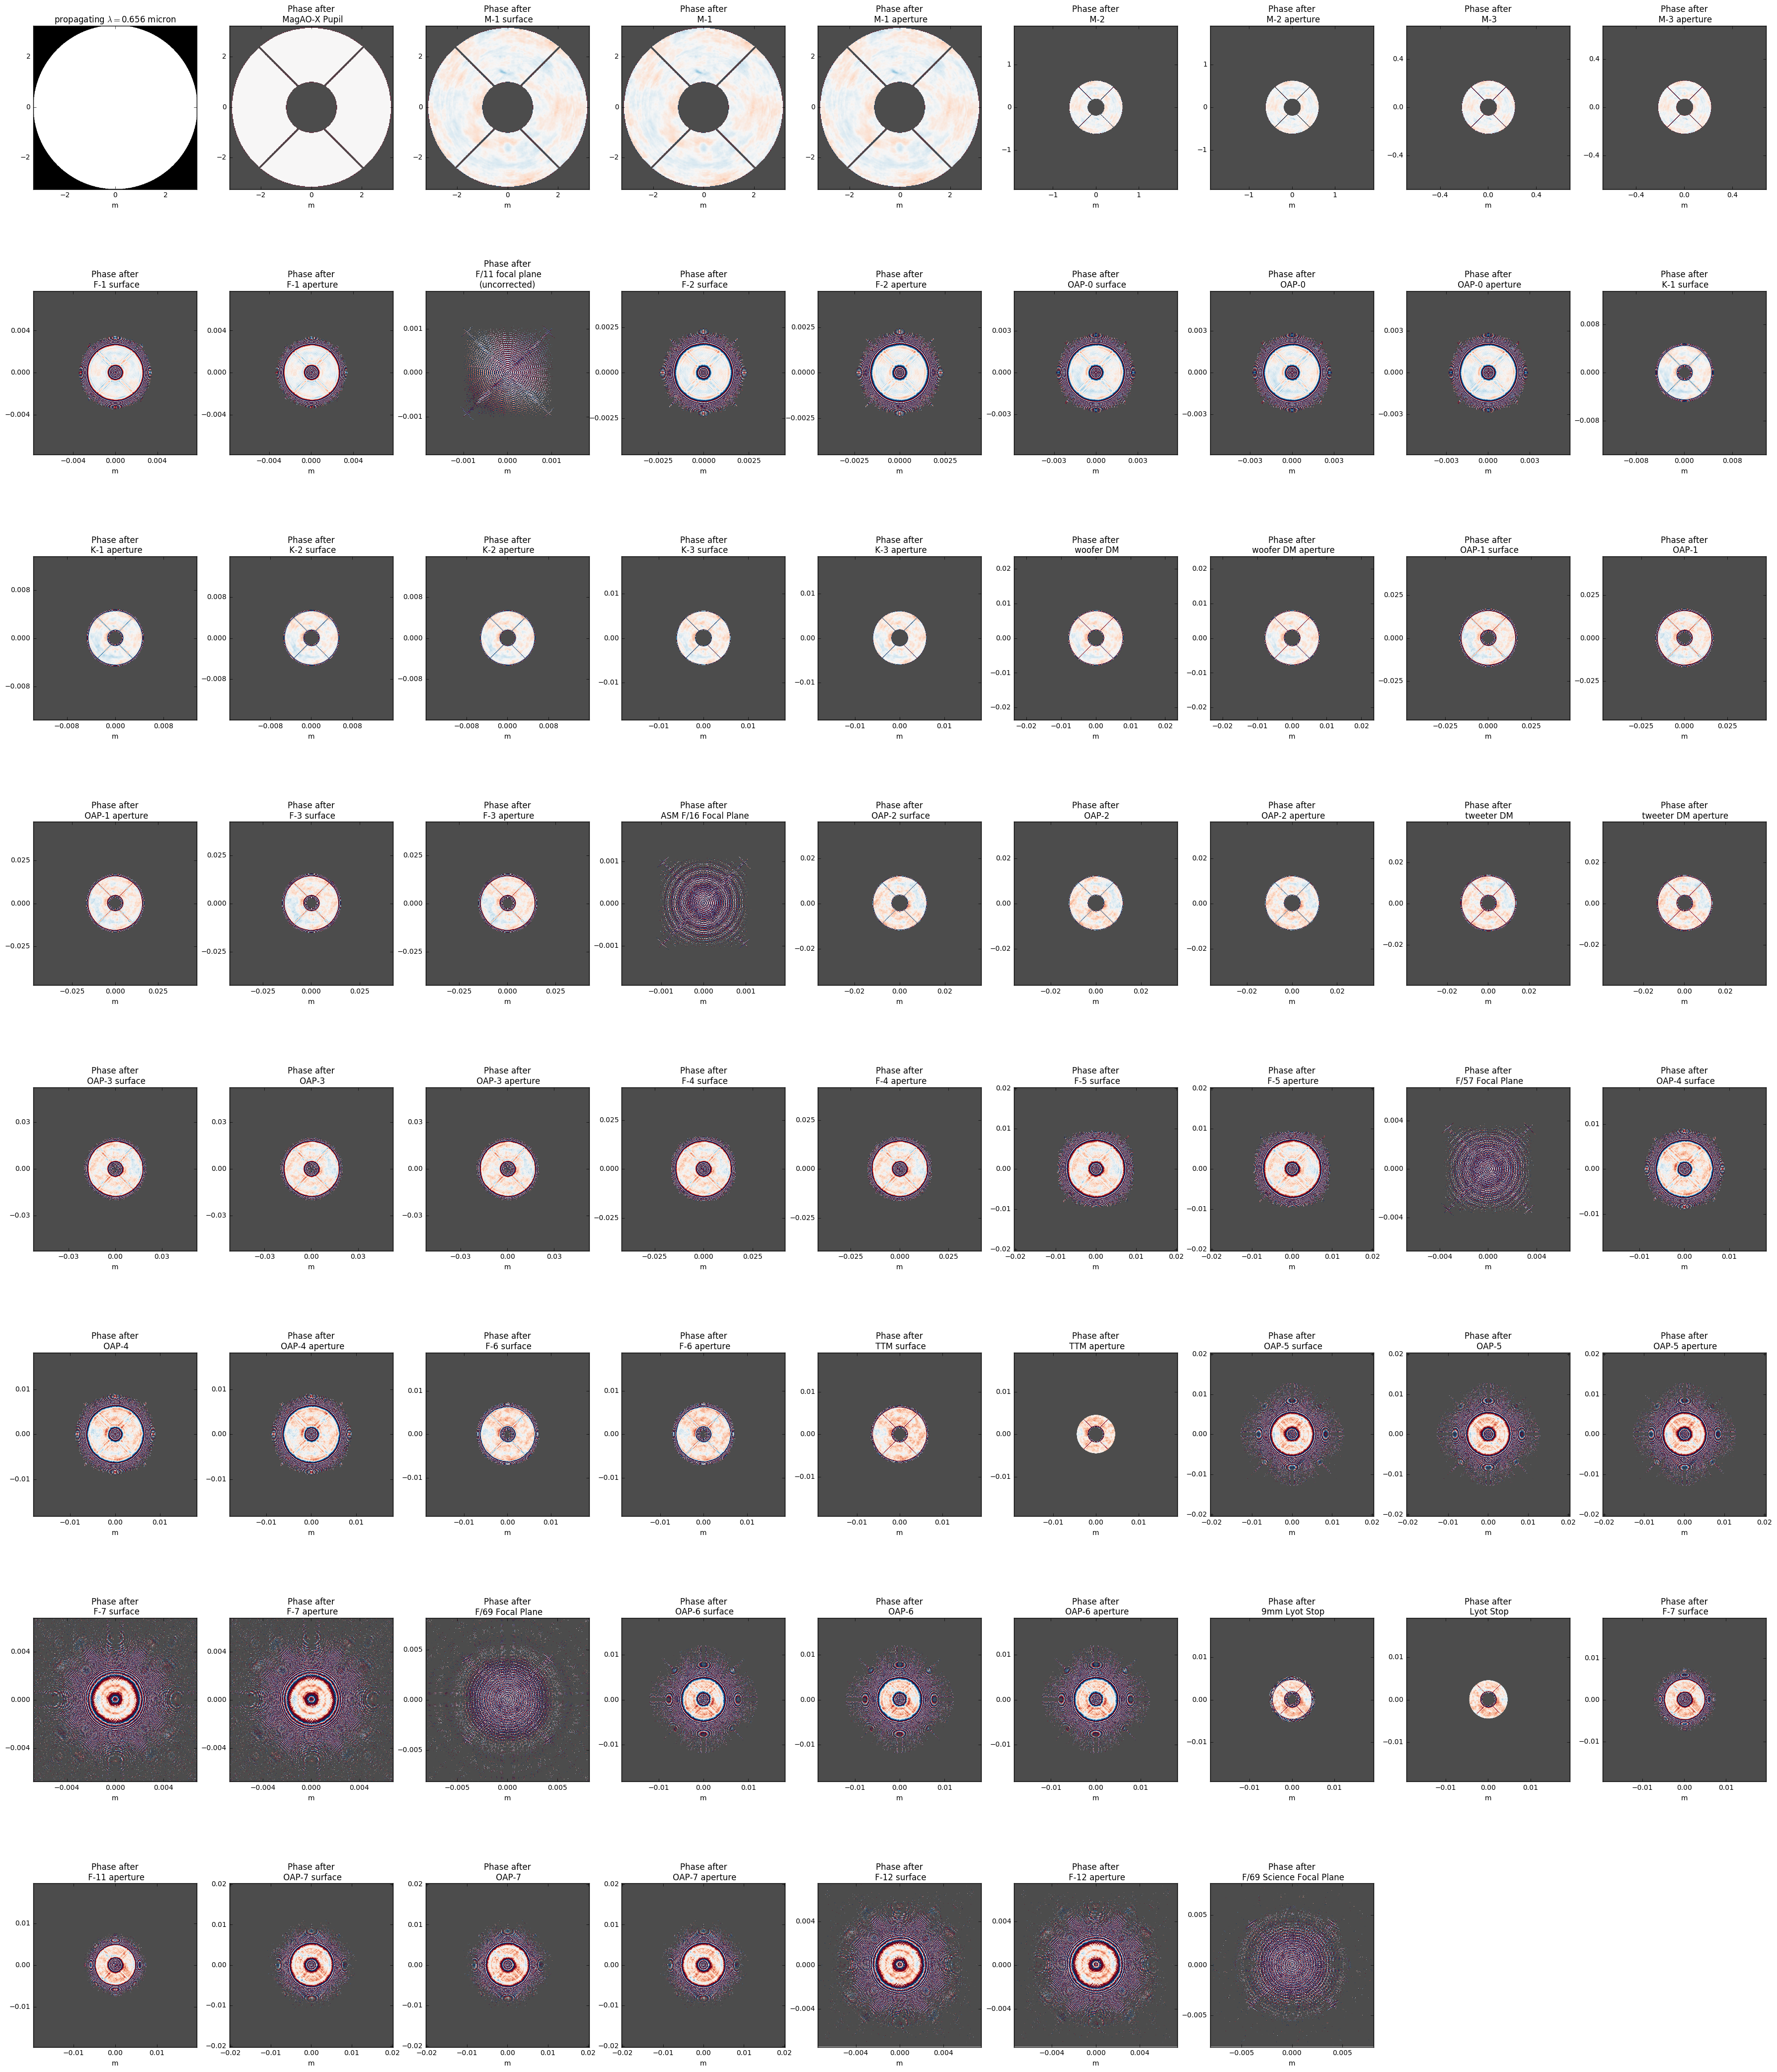

In [30]:
# Look at the corrected F/69 PSF
plt.figure(figsize=[45,54])
f69scifp_psf, f69scifp_wfs = magaox.calcPSF(wavelength=testWavelength,
                                      display_intermediates=True,
                                      return_intermediates=True,
                                      save_intermediates=True      )

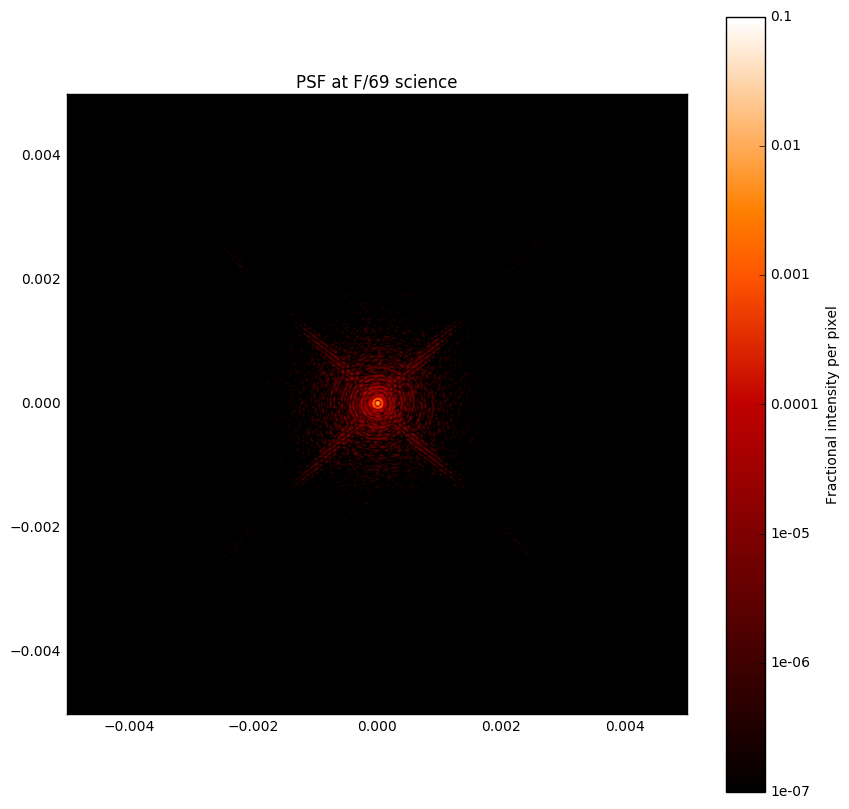

In [31]:
plt.figure(figsize=[10,10])
poppy.display_PSF(f69scifp_psf, imagecrop=0.01)
plt.title("PSF at F/69 science")

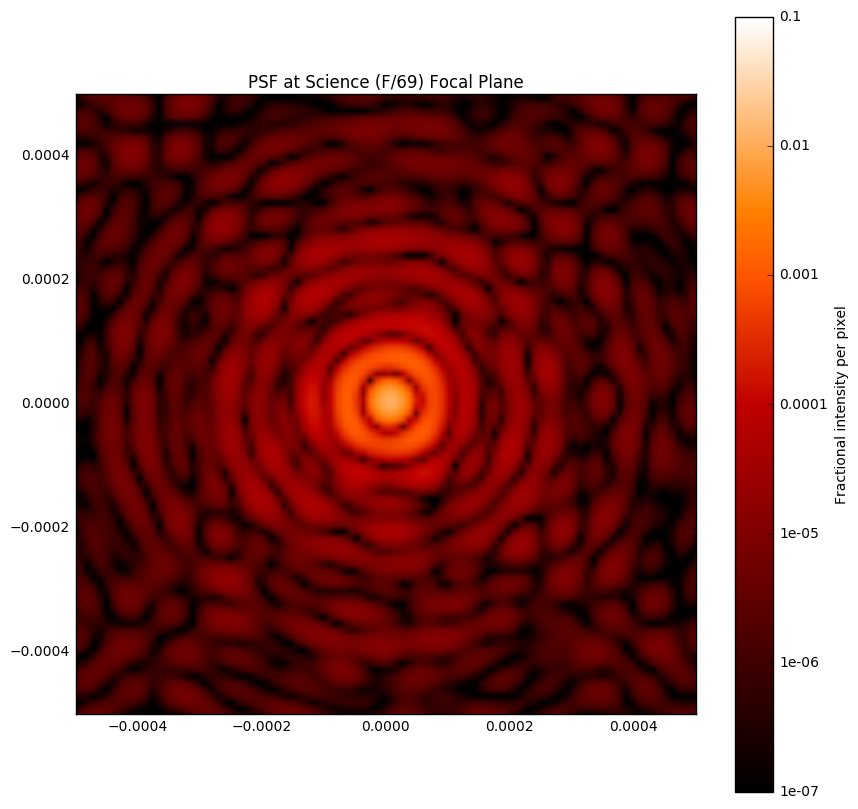

In [32]:
plt.figure(figsize=[10,10])
poppy.display_PSF(f69scifp_psf, imagecrop=0.001)
plt.title("PSF at Science (F/69) Focal Plane")

## Write PSF into FITS file

In [33]:
f69scifp_psf[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1536                                                  
NAXIS2  =                 1536                                                  
EXTEND  =                    T                                                  
PLANE1  = 'Wavefront Intensity'                                                 
WAVELEN = 6.56000000000000E-07 / Weighted mean wavelength in meters             
DIFFLMT =  0.02088625984934805 / Diffraction limit lambda/D in arcsec           
OVERSAMP=                    3 / Oversampling factor for FFTs in computation    
DET_SAMP=                    3 / Oversampling factor for MFT to detector plane  
PIXELSCL= 1.05861583581023E-05 / Pixel scale in meters/pixel                    
DIAM    =             6.4784

In [35]:
f69scifp_psf[0].writeto('f69scifp_WithAberration_PSF.fits')